### CIFAR-10 資料集

CIFAR-10是常用的彩色圖片資料集，它有如下的分类：“飞机”，“汽车”，“鸟”，“猫”，“鹿”，“狗”，“青蛙”，“马”，“船”，“卡车”等。在CIFAR-10里面的图片数据大小是3x32x32，即：三通道彩色图像，图像大小是32x32像素。

以下將按顺序進行下述步骤：

1. 通过torchvision加载CIFAR10里面的训练和测试数据集，并对数据进行标准化
2. 定义卷积神经网络
3. 定义损失函数
4. 利用训练数据训练网络
5. 利用测试数据测试网络


## 1. 資料載入及前處理

#### 使用torchvision 載入資料

In [8]:
import torch
import torchvision 
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 把Tensor轉成Image，方便視覺化

torchvision数据集加载完后的输出是范围在[0, 1]之间的PILImage。我们将其标准化为范围在[-1, 1]之间的张量。

In [9]:
# 定義對資料的預處理 
# image=(image-mean)/std

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
transform = transforms.Compose(
    [transforms.ToTensor(),      # 轉為Tensor
     transforms.Normalize(mean,std)])   # 轉為常態分佈標準化

# 訓練集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# 測試集
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ship


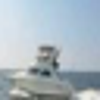

In [10]:
(data, label) = trainset[100]
print(classes[label])

#((data+1)/2) 是為了還原被標準化的資料
show((data+1)/2).resize((100,100))


#### 視覺化呈現資料

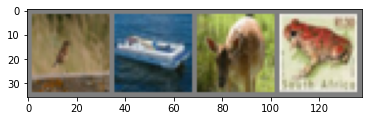

 bird  ship  deer  frog


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 随机获取训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. 定義神經網路(CNN)
将之前神经网络章节定义的神经网络拿过来，并将其修改成输入为3通道图像(替代原来定义的单通道图像）。

In [23]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 卷積層1 - 输入图像channel：3(彩色)；输出channel：6；5x5卷积核
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 3. 定義損失函數和最佳化器(Loss 、Optimizer)
使用多分类的交叉熵损失函数和随机梯度下降优化器(使用momentum）

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # 交叉熵
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. 訓練網路
重複執行以下流程：
- 輸入資料
- 正向傳播+反向傳播
- 更新參數

In [16]:
for epoch in range(2):  # loop over the dataset multiple times 僅訓練了2個epoch

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # i從0開始計數 
        
        # get the inputs 輸入資料
        inputs, labels = data

        # zero the parameter gradients 梯度清空為0
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # 更新參數
        optimizer.step()

        # print statistics
        running_loss += loss.item()  #如果是仅包含一个元素的tensor，可以使用.item()来得到对应的python数值
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0 # 每2000回　loss 歸零重計

print('Finished Training')

[1,  2000] loss: 1.145
[1,  4000] loss: 1.136
[1,  6000] loss: 1.137
[1,  8000] loss: 1.120
[1, 10000] loss: 1.145
[1, 12000] loss: 1.115
[2,  2000] loss: 1.037
[2,  4000] loss: 1.060
[2,  6000] loss: 1.067
[2,  8000] loss: 1.054
[2, 10000] loss: 1.028
[2, 12000] loss: 1.053
Finished Training


儲存訓練完的模型
看[这里](https://pytorch.org/docs/stable/notes/serialization.html)熟悉更多PyTorch保存模型的细节

In [21]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. 使用測試數據驗證結果

通过预测神经网络输出的标签来检查这个问题，并和正确样本进行(ground-truth）对比。如果预测是正确的，我们将样本添加到正确预测的列表中。

ok，第一步。让我们展示测试集中的图像来熟悉一下

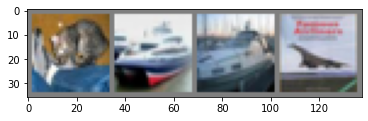

GroundTruth:    cat  ship  ship plane


In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 输出图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

載入保存的模型

In [26]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### 檢視模型判定的結果

In [27]:
outputs = net(images)

输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。让我们得到最高量值的下标/索引；

In [28]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car plane


神經網路在整個數據集上的表現

In [29]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        # 計算圖片在每個類別上的分數
        outputs = net(images)
        
        # 得分最高的那個類別
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


比随机选取(即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

那么哪些是表现好的类呢？哪些是表现的差的类呢？

In [30]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 74 %
Accuracy of  bird : 53 %
Accuracy of   cat : 43 %
Accuracy of  deer : 61 %
Accuracy of   dog : 41 %
Accuracy of  frog : 69 %
Accuracy of horse : 68 %
Accuracy of  ship : 76 %
Accuracy of truck : 73 %


### 在GPU上訓練
将一个张量传递给GPU一样，可以这样将神经网络转移到GPU上。

如果我们有cuda可用的话，让我们首先定义第一个设备为可见cuda设备：

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


本节的其余部分假设device是CUDA。

然后这些方法将递归遍历所有模块，并将它们的参数和缓冲区转换为CUDA张量：

In [33]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

请记住，我们不得不将输入和目标在每一步都送入GPU：

In [38]:
inputs, labels = inputs.to(device), labels.to(device)

为什么我们感受不到与CPU相比的巨大加速？因为我们的网络实在是太小了。

尝试一下：加宽你的网络(注意第一个nn.Conv2d的第二个参数和第二个nn.Conv2d的第一个参数要相同），看看能获得多少加速。

已实现的目标：

- 在更高层次上理解PyTorch的Tensor库和神经网络
- 训练一个小的神经网络做图片分类


In [39]:
device = torch.device("cuda: 0")
model.to(device)

NameError: name 'model' is not defined